In [33]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, RocCurveDisplay, auc, roc_curve
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error

from sklearn.model_selection import train_test_split
import seaborn as sns

sns.set_style(style="darkgrid", rc={"axes.facecolor": ".9", "grid.color": ".8"})
sns.set_palette(palette="deep")
sns_c = sns.color_palette(palette="deep")

### Load and drop non-numerical cols

In [116]:
#Load df
df = pd.read_csv("Model_data/station_data.csv")
station_names = df["station_names"]
df = df.drop(["Unnamed: 0","geometry", "CRS_code","station_names" ,"centroid", "nearest_geometry", "nearest_station_name", 
            "nearest_station_code", "Rail_Journey_Time_Cardiff_Central_mins", "car_journey_times", 
            'Sum Aged 15 and under',
            'Sum Aged 16 to 24', 'Sum Aged 25 to 34', 'Sum Aged 35 to 49',
            'Sum Aged 50 to 64', 'Sum Aged 65 and over', 'Sum TOTAL All ages'], axis=1)
df = df.rename(columns={"1_car_ratio": "one_cars_ratio", "2_cars_ratio": "two_cars_ratio", "3_or_more_cars_ratio": "three_or_more_cars_ratio"})

Analysis of the dataset

N/A vals

In [114]:
#df = df.drop(["Parking_Spaces"], axis = 1)
df.isna().sum()



nearest_station_distance                   0
Parking_Spaces                            27
Parking_Occupancy                         37
Journey_Time_Savings_By_Rail               4
Ratio_15_and_under                         2
Ratio_16_to_24                             2
Ratio_25_to_34                             2
Ratio_35_to_49                             2
Ratio_50_to_64                             2
Ratio_65_and_over                          2
No_cars_ratio                              0
one_cars_ratio                             0
two_cars_ratio                             0
three_or_more_cars_ratio                   0
average_catchment_LSOA_education_rank      0
average_catchment_LSOA_employment_rank     0
average_catchment_LSOA_income_rank         0
average_catchment_LSOA_health_rank         0
average_catchment_LSOA_overall_rank        0
fares_pence                               37
Rail_Share                                 0
dtype: int64

In [118]:
df = df.drop(columns=["Parking_Occupancy"])
df = df.dropna()
#df = df.drop(columns=["fares_pence"])

array([[<Axes: xlabel='nearest_station_distance', ylabel='nearest_station_distance'>,
        <Axes: xlabel='Parking_Spaces', ylabel='nearest_station_distance'>,
        <Axes: xlabel='Journey_Time_Savings_By_Rail', ylabel='nearest_station_distance'>,
        <Axes: xlabel='Ratio_15_and_under', ylabel='nearest_station_distance'>,
        <Axes: xlabel='Ratio_16_to_24', ylabel='nearest_station_distance'>,
        <Axes: xlabel='Ratio_25_to_34', ylabel='nearest_station_distance'>,
        <Axes: xlabel='Ratio_35_to_49', ylabel='nearest_station_distance'>,
        <Axes: xlabel='Ratio_50_to_64', ylabel='nearest_station_distance'>,
        <Axes: xlabel='Ratio_65_and_over', ylabel='nearest_station_distance'>,
        <Axes: xlabel='No_cars_ratio', ylabel='nearest_station_distance'>,
        <Axes: xlabel='one_cars_ratio', ylabel='nearest_station_distance'>,
        <Axes: xlabel='two_cars_ratio', ylabel='nearest_station_distance'>,
        <Axes: xlabel='three_or_more_cars_ratio', ylabel='

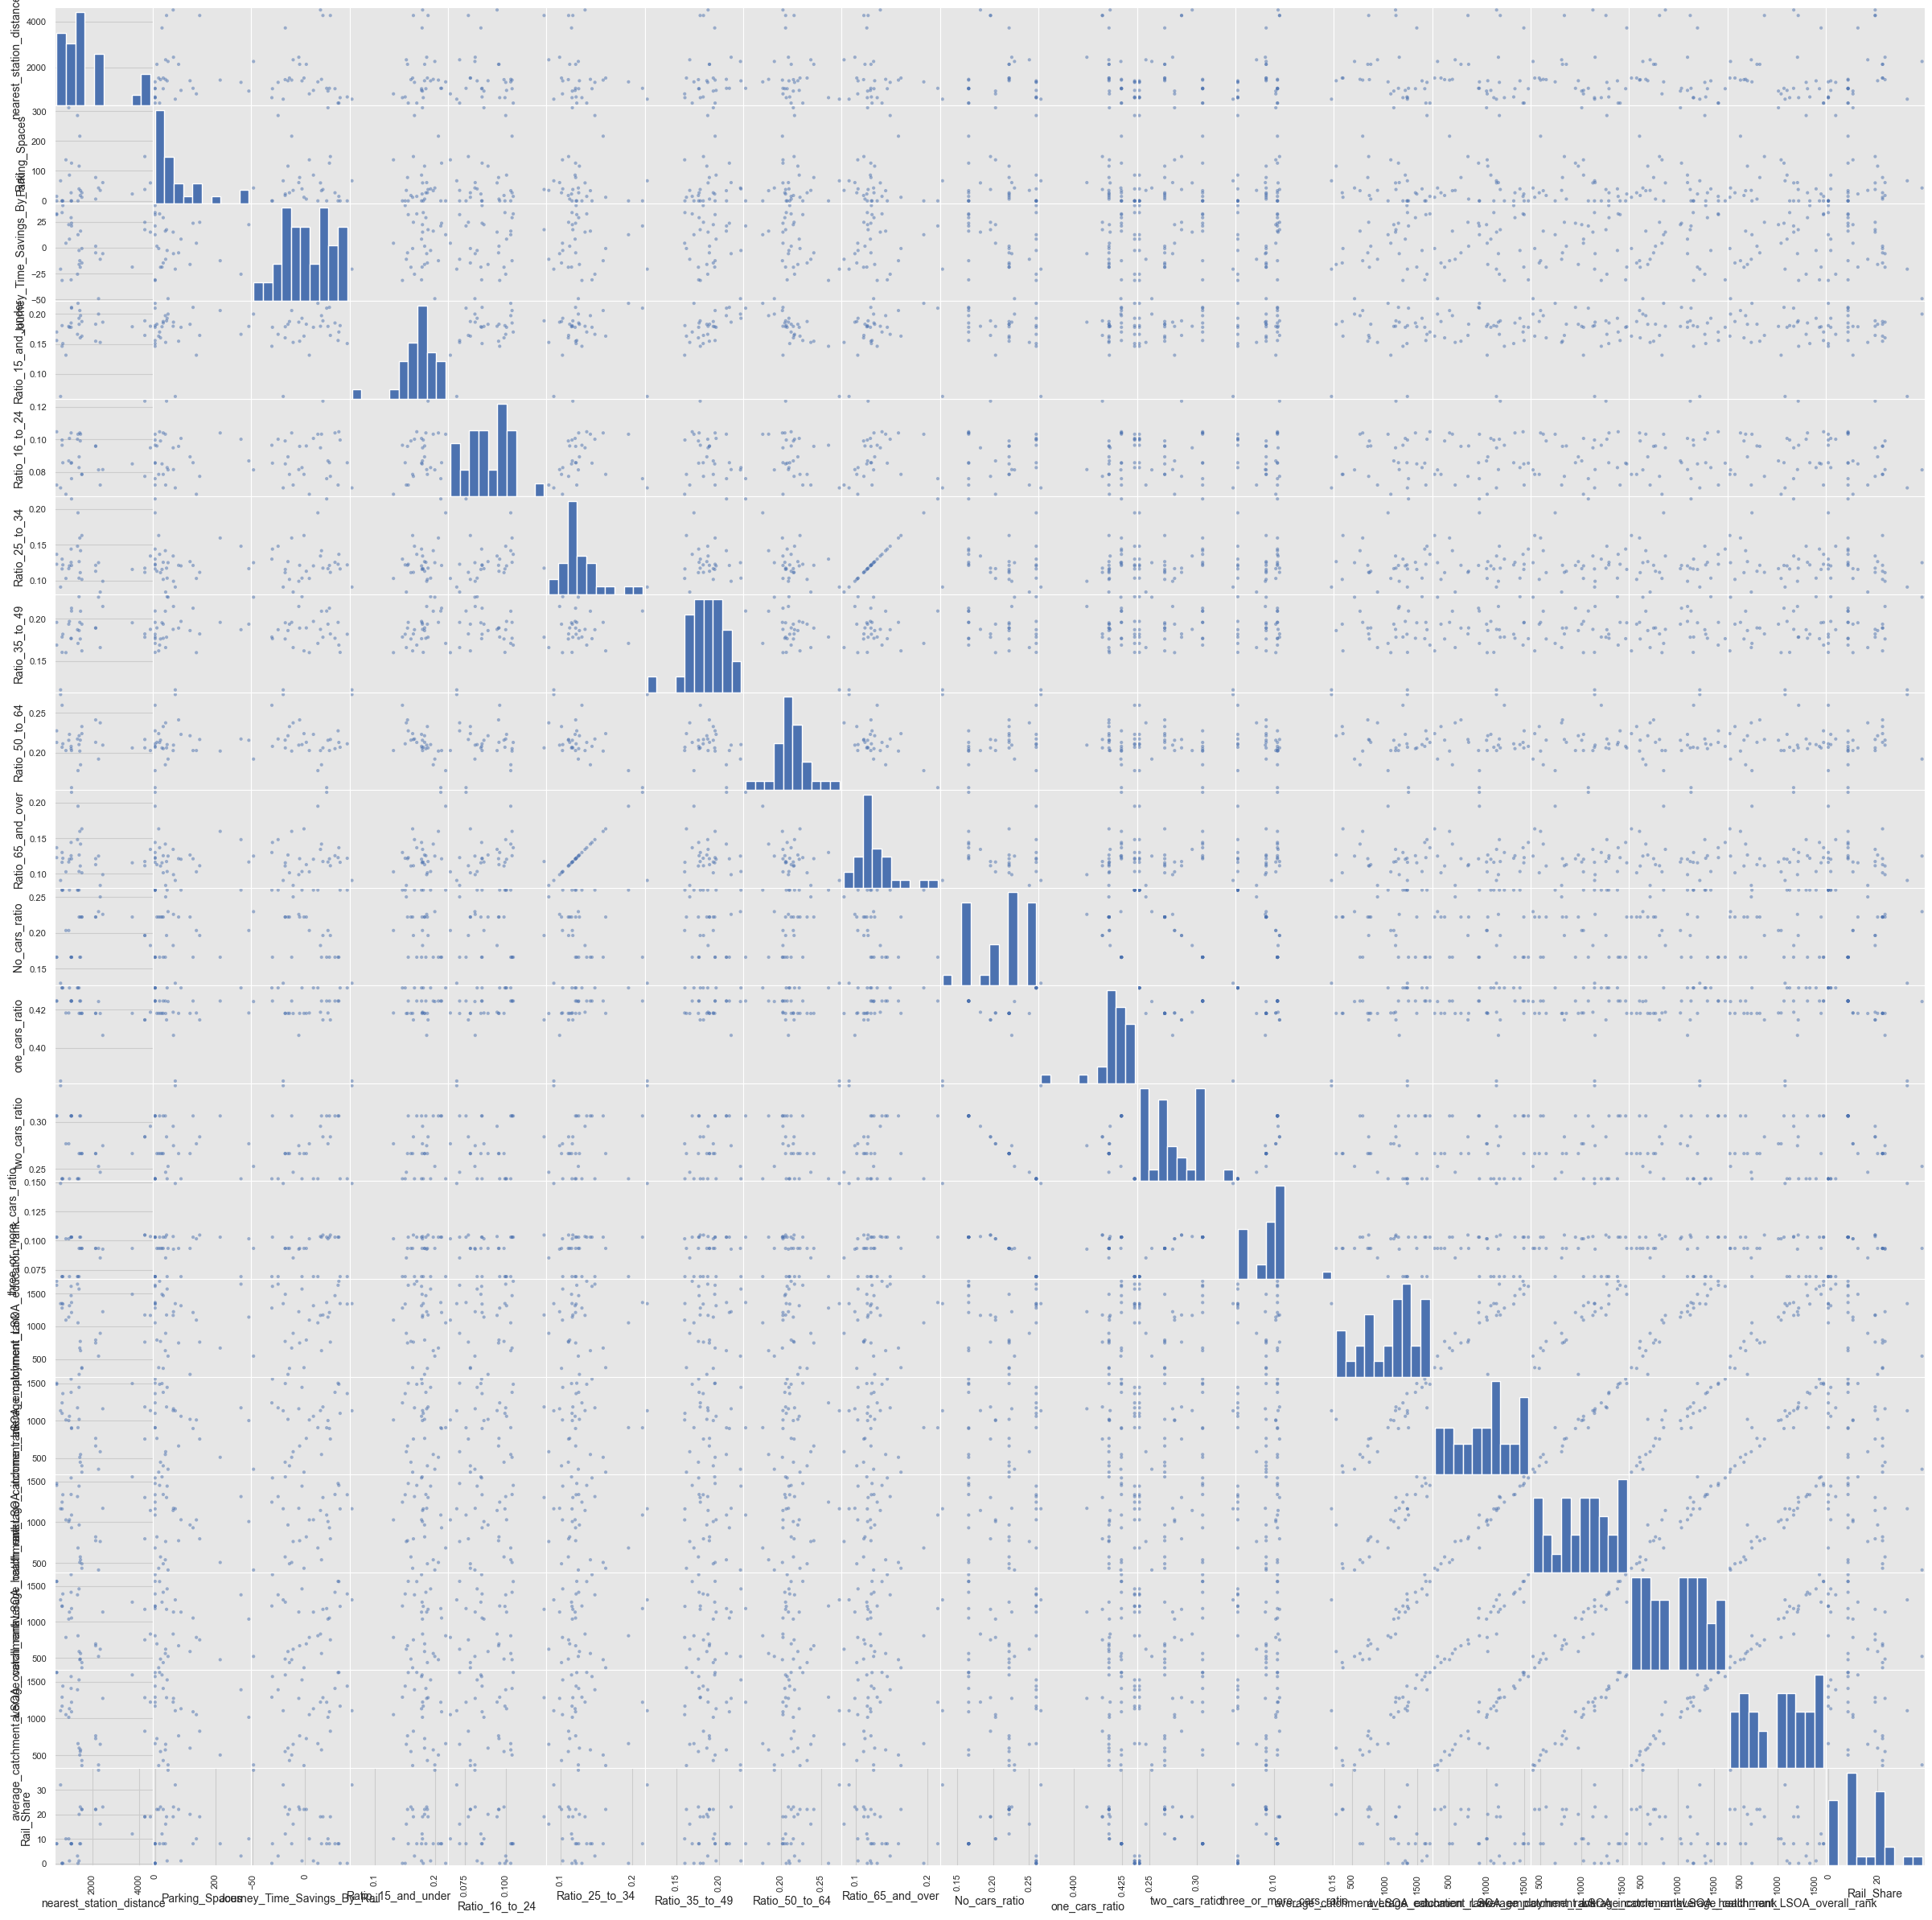

In [78]:
pd.plotting.scatter_matrix(df, figsize=(30, 30))

Check Relationships

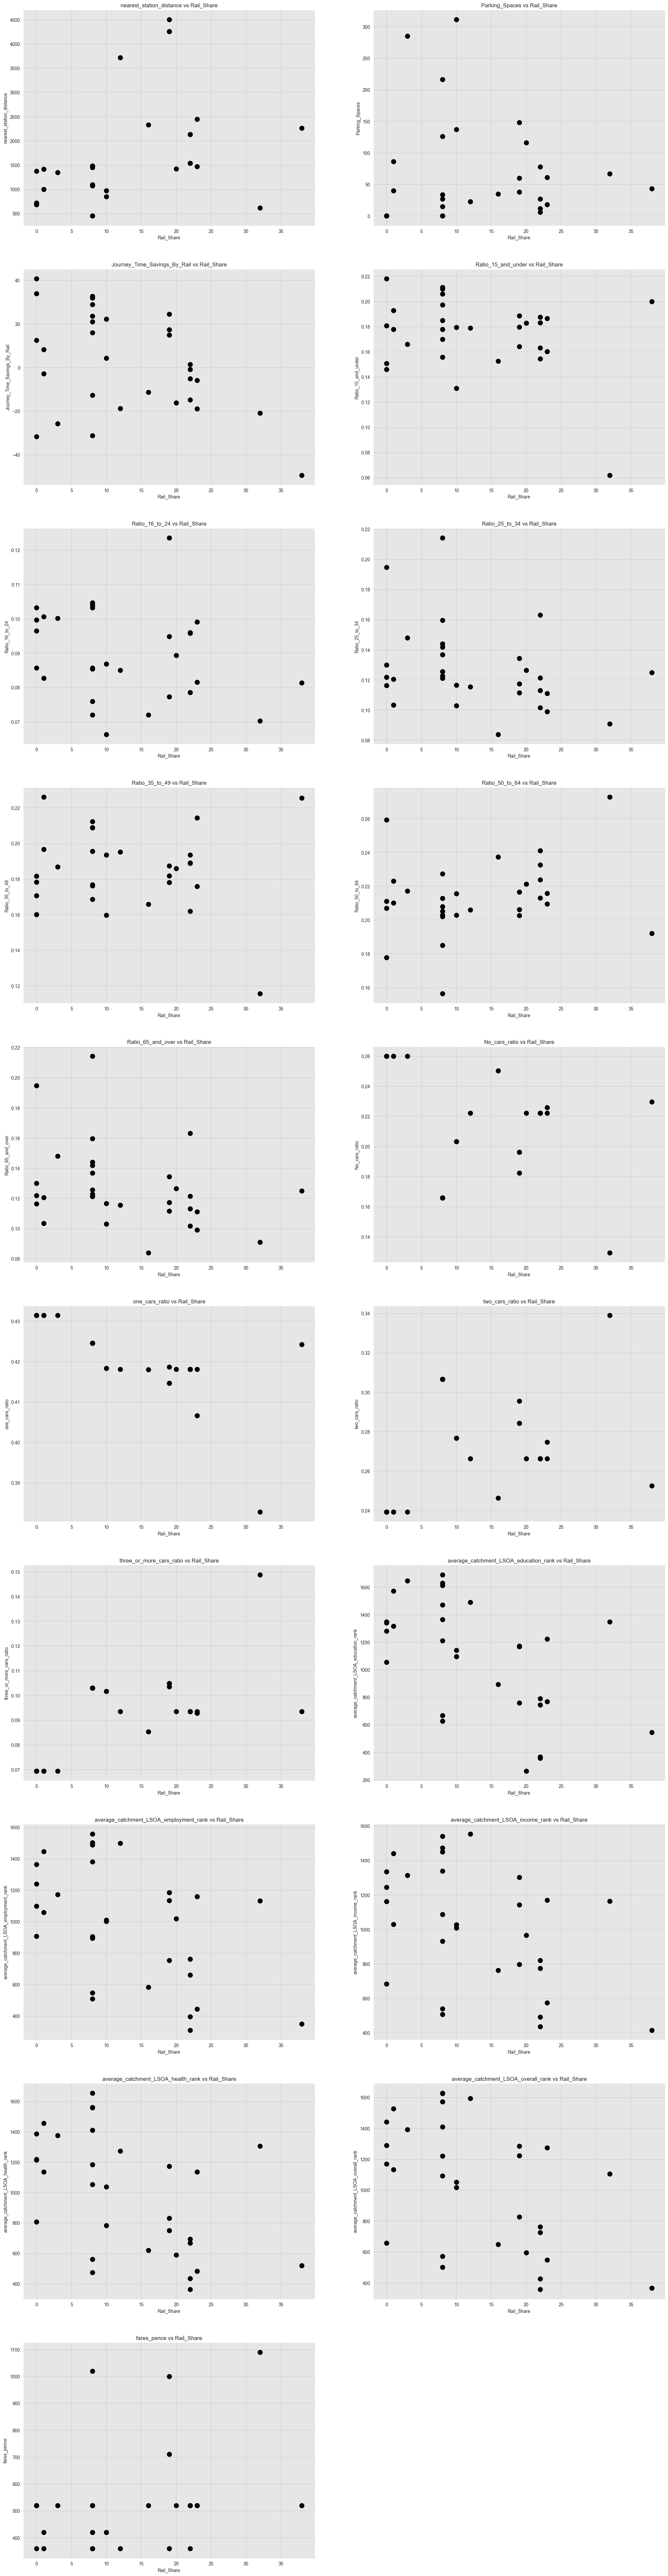

In [119]:
# Subplots are organized in a Rows x Cols Grid
# Tot and Cols are known

Tot = len(list(df.drop(columns=["Rail_Share"]).keys()))
Cols = 2

# Compute Rows required

Rows = Tot // Cols 

#     EDIT for correct number of rows:
#     If one additional row is necessary -> add one:

if Tot % Cols != 0:
    Rows += 1

# Create a Position index
Position = range(1,Tot + 1)

fig = plt.figure(figsize=(25, 100))

for i, pred in enumerate(list(df.drop(columns=["Rail_Share"]).keys())):
    ax = fig.add_subplot(Rows,Cols,Position[i])
    ax.plot(df["Rail_Share"], df[pred], "o",color = "black", markersize=10 )
    plt.xlabel("Rail_Share")
    plt.ylabel(pred)
    plt.title(pred + " vs " + "Rail_Share")

plt.show()
    

Starting Linear Model

In [120]:
from sklearn.linear_model import LinearRegression

# Fitting the model
rail_model = LinearRegression()
rail_model.fit(df.loc[:, df.columns != 'Rail_Share'], df["Rail_Share"])

# Returning the R^2 for the model
model_r2 = rail_model.score(df.loc[:, df.columns != 'Rail_Share'], df["Rail_Share"])
print('R^2: {0}'.format(model_r2))


R^2: 0.8889118320029306


# Linear Regression Assumption Testing

See Gauss-Markov Theorem and OLS assumptins

Linearity 

Assumption 1: Linear Relationship between the Target and the Feature 

Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.


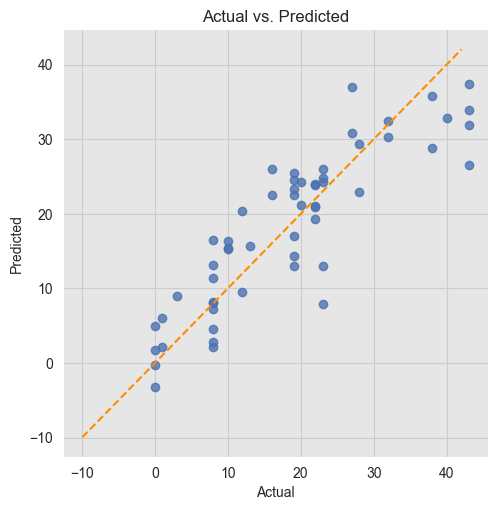

In [40]:
def calculate_residuals(model, features, target):
    predictions = model.predict(features)
    df_results = pd.DataFrame({'Actual': target, 'Predicted': predictions})
    df_results['Residuals'] = abs(df_results['Actual']) - abs(df_results['Predicted'])
    
    return df_results

def linear_assumption(model, features, target):
    """
    Linearity: Assumes that there is a linear relationship between the predictors and
               the response variable. If not, either a quadratic term or another
               algorithm should be used.
    """
    print('Assumption 1: Linear Relationship between the Target and the Feature', '\n')
        
    print('Checking with a scatter plot of actual vs. predicted.',
           'Predictions should follow the diagonal line.')
    
    # Calculating residuals for the plot
    df_results = calculate_residuals(model, features, target)
    
    # Plotting the actual vs predicted values
    sns.lmplot(x='Actual', y='Predicted', data=df_results, fit_reg=False)
        
    # Plotting the diagonal line
    line_coords = np.arange(df_results.min().min(), df_results.max().max())
    plt.plot(line_coords, line_coords,  # X and y points
             color='darkorange', linestyle='--')
    plt.title('Actual vs. Predicted')
    plt.show()

linear_assumption(rail_model,df.loc[:, df.columns != 'Rail_Share'], df["Rail_Share"] )

Normality of errors

Assumption 2: The error terms are normally distributed 

Using the Anderson-Darling test for normal distribution
p-value from the test (our threshold is 0.05): 0.06679462187372032
Residuals are normally distributed


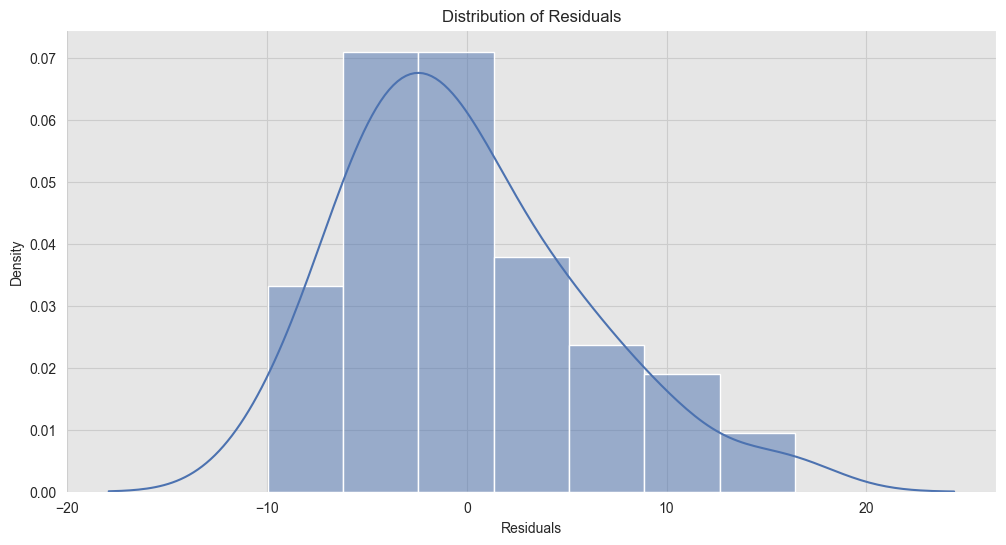


Assumption satisfied


In [41]:
def normal_errors_assumption(model, features, target, p_value_thresh=0.05):
    """
    Normality: Assumes that the error terms are normally distributed. If they are not,
    nonlinear transformations of variables may solve this.
               
    This assumption being violated primarily causes issues with the confidence intervals
    """
    from statsmodels.stats.diagnostic import normal_ad
    print('Assumption 2: The error terms are normally distributed', '\n')
    
    # Calculating residuals for the Anderson-Darling test
    df_results = calculate_residuals(model, features, target)
    
    print('Using the Anderson-Darling test for normal distribution')

    # Performing the test on the residuals
    p_value = normal_ad(df_results['Residuals'])[1]
    print('p-value from the test (our threshold is 0.05):', p_value)
    
    # Reporting the normality of the residuals
    if p_value < p_value_thresh:
        print('Residuals are not normally distributed')
    else:
        print('Residuals are normally distributed')
    
    # Plotting the residuals distribution
    plt.subplots(figsize=(12, 6))
    plt.title('Distribution of Residuals')
    sns.histplot(df_results['Residuals'], kde=True,stat="density", kde_kws=dict(cut=3))
    plt.show()
    
    print()
    if p_value > p_value_thresh:
        print('Assumption satisfied')
    else:
        print('Assumption not satisfied')
        print()
        print('Confidence intervals will likely be affected')
        print('Try performing nonlinear transformations on variables')

normal_errors_assumption(rail_model, df.loc[:, df.columns != 'Rail_Share'], df["Rail_Share"])

Multicollinearity

Assumption 3: Little to no multicollinearity among predictors


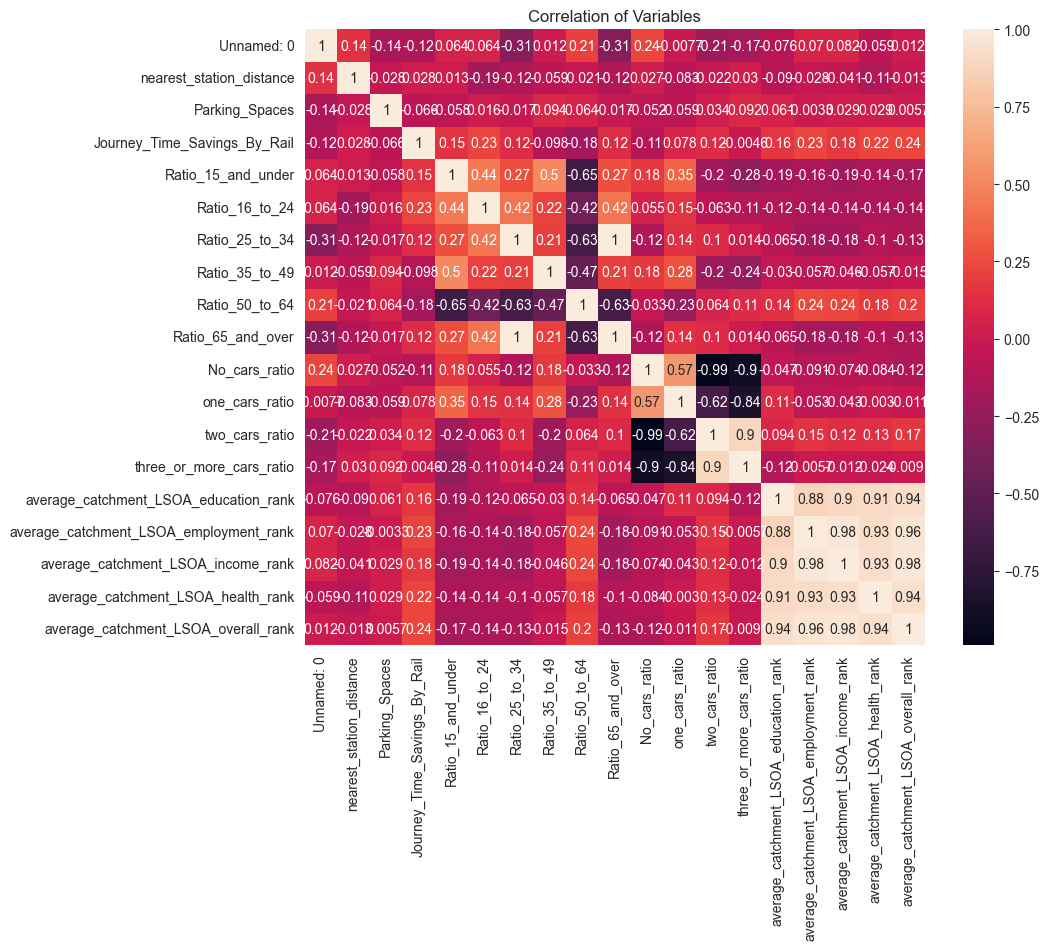

Variance Inflation Factors (VIF)
> 10: An indication that multicollinearity may be present
> 100: Certain multicollinearity among the variables
-------------------------------------
Unnamed: 0: 1.6309970177484947
nearest_station_distance: 1.351924012564997
Parking_Spaces: 1.2455546945630913
Journey_Time_Savings_By_Rail: 1.66491320324481
Ratio_15_and_under: 3.1347219620065006
Ratio_16_to_24: 1.712917865766547
Ratio_25_to_34: inf
Ratio_35_to_49: 1.92723105404428
Ratio_50_to_64: 3.963056905085182
Ratio_65_and_over: inf
No_cars_ratio: 605.1852144477562
one_cars_ratio: 4427.257909393117
two_cars_ratio: 4475.251785266936
three_or_more_cars_ratio: 698.7987677511896
average_catchment_LSOA_education_rank: 18.79860444252286
average_catchment_LSOA_employment_rank: 30.667340015336432
average_catchment_LSOA_income_rank: 56.63816802110512
average_catchment_LSOA_health_rank: 13.040663931279338
average_catchment_LSOA_overall_rank: 64.79248981523577

11 cases of possible multicollinearity
6 cases of de

c:\Users\Ashley\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


In [42]:
def multicollinearity_assumption(model, features, target, feature_names=None):
    """
    Multicollinearity: Assumes that predictors are not correlated with each other. If there is
                       correlation among the predictors, then either remove prepdictors with high
                       Variance Inflation Factor (VIF) values or perform dimensionality reduction
                           
                       This assumption being violated causes issues with interpretability of the 
                       coefficients and the standard errors of the coefficients.
    """
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    print('Assumption 3: Little to no multicollinearity among predictors')
        
    # Plotting the heatmap
    plt.figure(figsize = (10,8))
    sns.heatmap(pd.DataFrame(features, columns=feature_names).corr(), annot=True)
    plt.title('Correlation of Variables')
    plt.show()
        
    print('Variance Inflation Factors (VIF)')
    print('> 10: An indication that multicollinearity may be present')
    print('> 100: Certain multicollinearity among the variables')
    print('-------------------------------------')
       
    # Gathering the VIF for each variable
    VIF = [variance_inflation_factor(features, i) for i in range(features.shape[1])]
    for idx, vif in enumerate(VIF):
        print('{0}: {1}'.format(feature_names[idx], vif))
        
    # Gathering and printing total cases of possible or definite multicollinearity
    possible_multicollinearity = sum([1 for vif in VIF if vif > 10])
    definite_multicollinearity = sum([1 for vif in VIF if vif > 100])
    print()
    print('{0} cases of possible multicollinearity'.format(possible_multicollinearity))
    print('{0} cases of definite multicollinearity'.format(definite_multicollinearity))
    print()

    if definite_multicollinearity == 0:
        if possible_multicollinearity == 0:
            print('Assumption satisfied')
        else:
            print('Assumption possibly satisfied')
            print()
            print('Coefficient interpretability may be problematic')
            print('Consider removing variables with a high Variance Inflation Factor (VIF)')

    else:
        print('Assumption not satisfied')
        print()
        print('Coefficient interpretability will be problematic')
        print('Consider removing variables with a high Variance Inflation Factor (VIF)')

main_pred = list(df.drop(columns=["Rail_Share"]).keys())
multicollinearity_assumption(rail_model, df.loc[:, df.columns != 'Rail_Share'], df["Rail_Share"], main_pred)

Autocorrelation (errors are independent)

In [43]:
def autocorrelation_assumption(model, features, label):
    """
    Autocorrelation: Assumes that there is no autocorrelation in the residuals. If there is
                     autocorrelation, then there is a pattern that is not explained due to
                     the current value being dependent on the previous value.
                     This may be resolved by adding a lag variable of either the dependent
                     variable or some of the predictors.
    """
    from statsmodels.stats.stattools import durbin_watson
    print('Assumption 4: No Autocorrelation', '\n')
    
    # Calculating residuals for the Durbin Watson-tests
    df_results = calculate_residuals(model, features, label)

    print('\nPerforming Durbin-Watson Test')
    print('Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data')
    print('0 to 2< is positive autocorrelation')
    print('>2 to 4 is negative autocorrelation')
    print('-------------------------------------')
    durbinWatson = durbin_watson(df_results['Residuals'])
    print('Durbin-Watson:', durbinWatson)
    if durbinWatson < 1.5:
        print('Signs of positive autocorrelation', '\n')
        print('Assumption not satisfied')
    elif durbinWatson > 2.5:
        print('Signs of negative autocorrelation', '\n')
        print('Assumption not satisfied')
    else:
        print('Little to no autocorrelation', '\n')
        print('Assumption satisfied')

autocorrelation_assumption(rail_model, df.loc[:, df.columns != 'Rail_Share'], df["Rail_Share"])

Assumption 4: No Autocorrelation 


Performing Durbin-Watson Test
Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data
0 to 2< is positive autocorrelation
>2 to 4 is negative autocorrelation
-------------------------------------
Durbin-Watson: 1.846622342182189
Little to no autocorrelation 

Assumption satisfied


Homoscedasticity

Assumption 5: Homoscedasticity of Error Terms 

Residuals should have relative constant variance


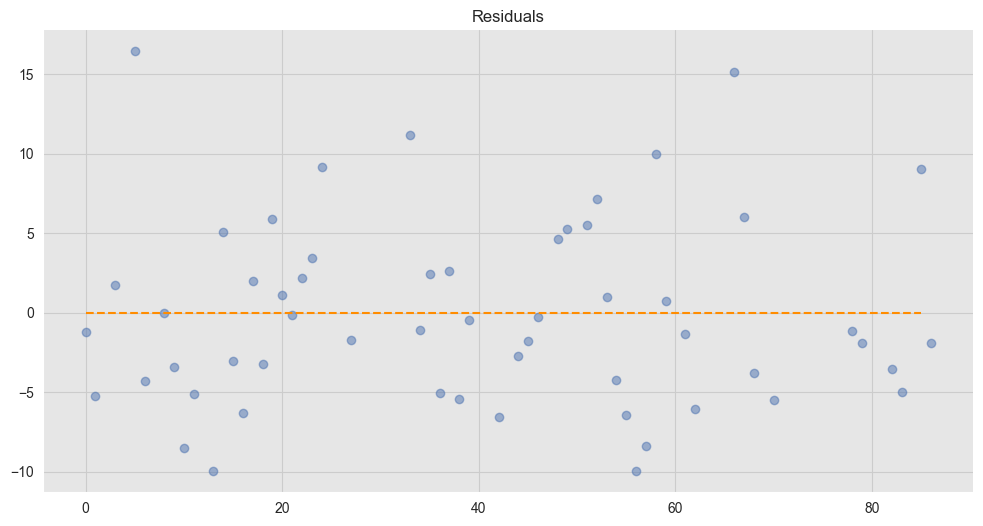

In [44]:
def homoscedasticity_assumption(model, features, label):
    """
    Homoscedasticity: Assumes that the errors exhibit constant variance
    """
    print('Assumption 5: Homoscedasticity of Error Terms', '\n')
    
    print('Residuals should have relative constant variance')
        
    # Calculating residuals for the plot
    df_results = calculate_residuals(model, features, label)

    # Plotting the residuals
    plt.subplots(figsize=(12, 6))
    ax = plt.subplot(111)  # To remove spines
    plt.scatter(x=df_results.index, y=df_results.Residuals, alpha=0.5)
    plt.plot(np.repeat(0, df_results.index.max()), color='darkorange', linestyle='--')
    ax.spines['right'].set_visible(False)  # Removing the right spine
    ax.spines['top'].set_visible(False)  # Removing the top spine
    plt.title('Residuals')
    plt.show()  


homoscedasticity_assumption(rail_model, df.loc[:, df.columns != 'Rail_Share'], df["Rail_Share"])


There appears to be heteroscedacity, maybe use a generalised least squares (GLS)? Or use Log form of target?

R^2: 0.8753667983587519
Assumption 5: Homoscedasticity of Error Terms 

Residuals should have relative constant variance


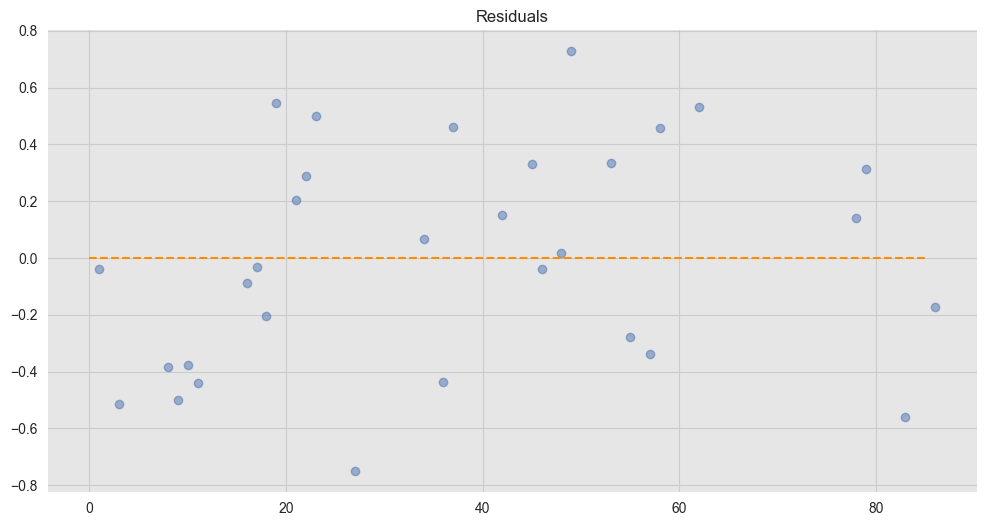

In [121]:
test = df.copy()
test["Rail_Share"] = np.log(test["Rail_Share"]+1)
# Fitting the model
rail_model = LinearRegression()
rail_model.fit(test.loc[:, test.columns != 'Rail_Share'], test["Rail_Share"])

# Returning the R^2 for the model
model_r2 = rail_model.score(test.loc[:, test.columns != 'Rail_Share'], test["Rail_Share"])
print('R^2: {0}'.format(model_r2))
homoscedasticity_assumption(rail_model, test.loc[:, test.columns != 'Rail_Share'], test["Rail_Share"])


Taking log seems to amplify it. See Variance-stabilizing transformation to remove this. This may not be problematic when interpreting coefficients (Since OLS parameters are unbiased), but affects confidence intervals and standard errors.

### Preprocessing

Assumption 3: Little to no multicollinearity among predictors


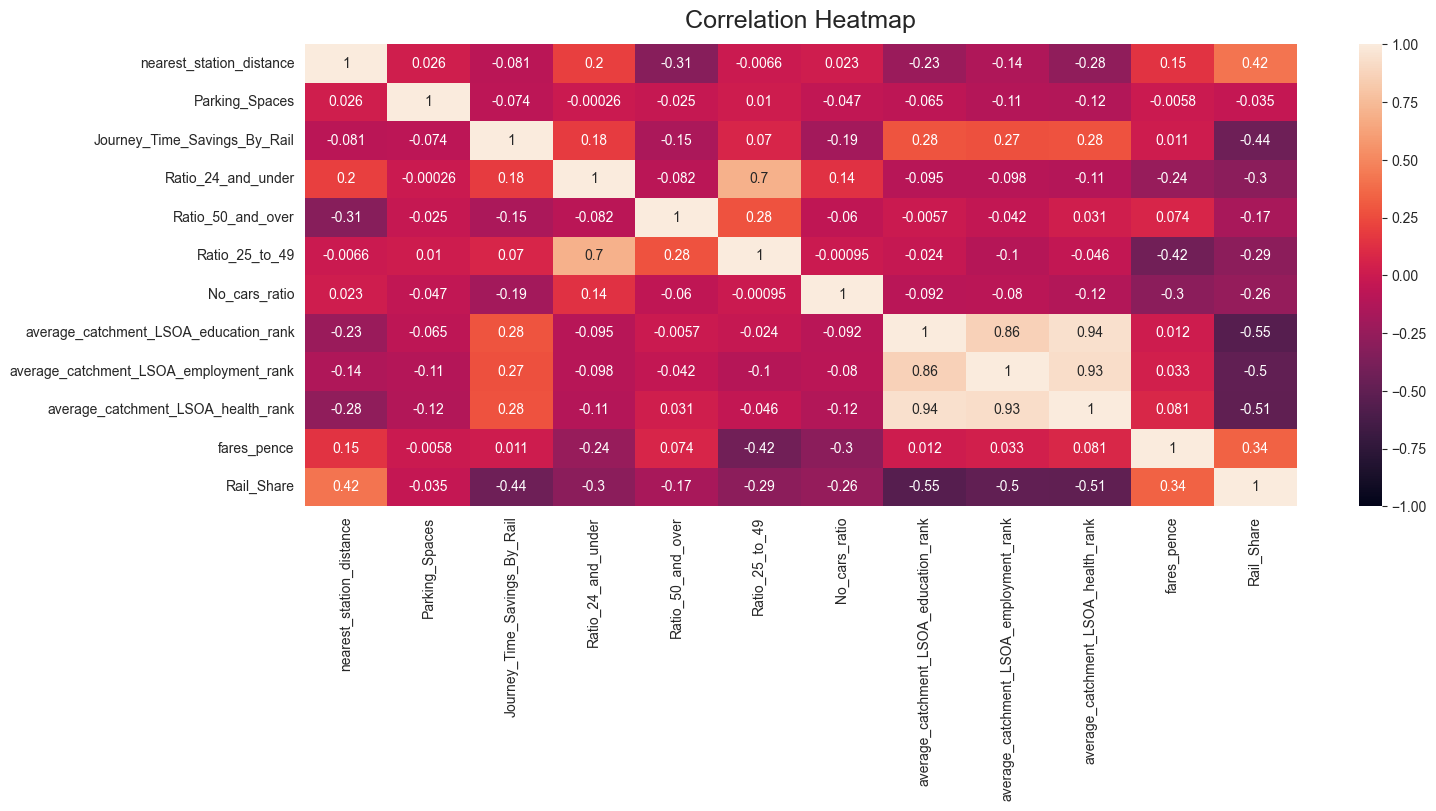

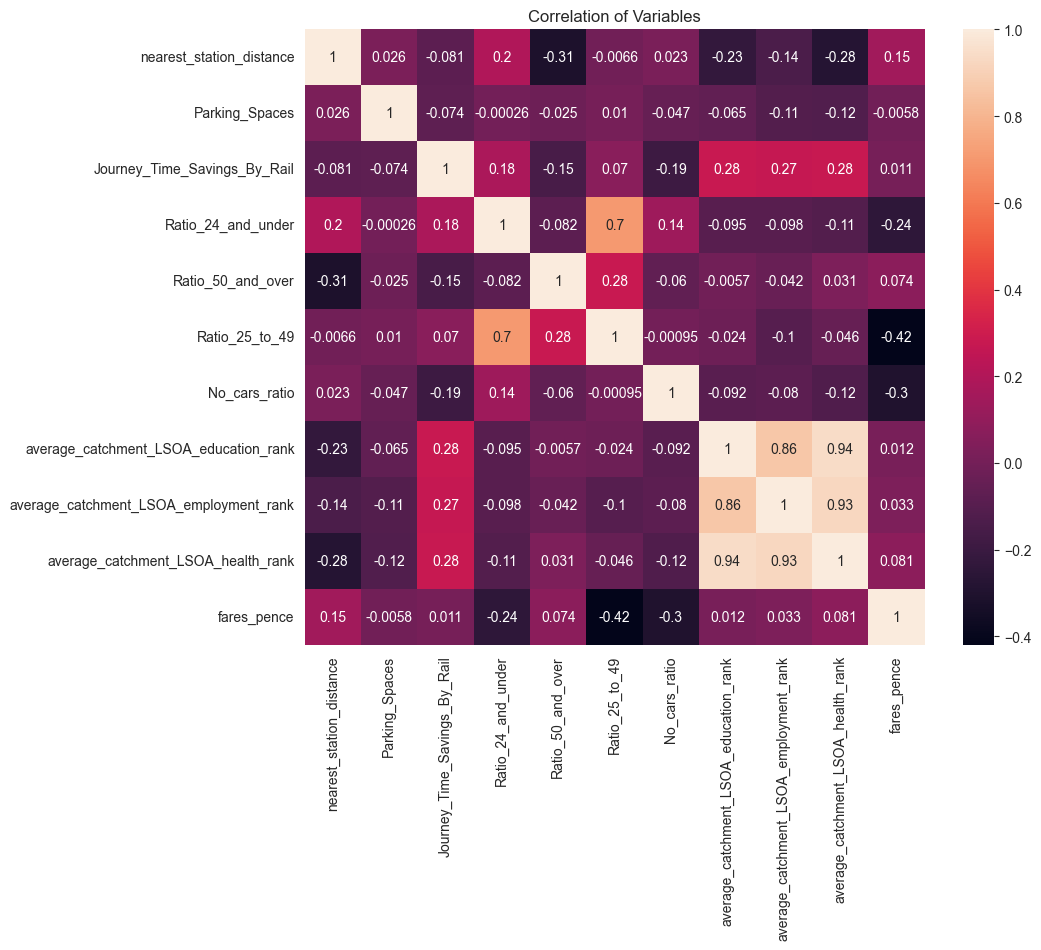

Variance Inflation Factors (VIF)
> 10: An indication that multicollinearity may be present
> 100: Certain multicollinearity among the variables
-------------------------------------
nearest_station_distance: 5.181091858163695
Parking_Spaces: 1.7213973853414233
Journey_Time_Savings_By_Rail: 1.2690192079334977
Ratio_24_and_under: 151.2325816533668
Ratio_50_and_over: 202.44208652750783
Ratio_25_to_49: 278.65859523937013
No_cars_ratio: 36.79153822553635
average_catchment_LSOA_education_rank: 87.31069876619566
average_catchment_LSOA_employment_rank: 77.5725153296504
average_catchment_LSOA_health_rank: 185.41277083132428
fares_pence: 15.94220502989528

8 cases of possible multicollinearity
4 cases of definite multicollinearity

Assumption not satisfied

Coefficient interpretability will be problematic
Consider removing variables with a high Variance Inflation Factor (VIF)


In [123]:
final_df = df.copy()

#Combine Population Age Ratios to working age ratios
#Log form of target (With zeros, the log form is y=log(x+1))

final_df["Ratio_25_to_49"] = final_df["Ratio_25_to_34"] + final_df["Ratio_35_to_49"]
mid = final_df['Ratio_25_to_49']
final_df.drop(labels=['Ratio_25_to_49'], axis=1,inplace = True)
final_df.insert(4, 'Ratio_25_to_49', mid)
final_df = final_df.drop(columns = ["Ratio_25_to_34", "Ratio_35_to_49"])

final_df["Ratio_24_and_under"] = final_df["Ratio_15_and_under"] + final_df["Ratio_16_to_24"]
mid = final_df['Ratio_24_and_under']
final_df.drop(labels=['Ratio_24_and_under'], axis=1,inplace = True)
final_df.insert(4, 'Ratio_24_and_under', mid)
final_df = final_df.drop(columns = ["Ratio_15_and_under", "Ratio_16_to_24"])

final_df["Ratio_50_and_over"] = final_df["Ratio_50_to_64"] + final_df["Ratio_65_and_over"]
mid = final_df['Ratio_50_and_over']
final_df.drop(labels=['Ratio_50_and_over'], axis=1,inplace = True)
final_df.insert(4, 'Ratio_50_and_over', mid)
final_df = final_df.drop(columns = ["Ratio_50_to_64", "Ratio_65_and_over"])

#Drop car ownership Ratios (1 - no car ownership = car ownership ratio (no loss of info other than no. of cars))
final_df = final_df.drop(columns = ["one_cars_ratio", "two_cars_ratio", "three_or_more_cars_ratio"])
final_df = final_df.drop(columns = ["average_catchment_LSOA_overall_rank", "average_catchment_LSOA_income_rank"])

main_pred = list(final_df.drop(columns=["Rail_Share"]).keys())
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(final_df.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12)
multicollinearity_assumption(rail_model, final_df.loc[:, final_df.columns != 'Rail_Share'], final_df["Rail_Share"], main_pred)


In [131]:
#Variable selection based on adjusted R^2 
def select_variable_adj_r2(df, main_pred, main_target):
    
    not_done_selection = True #Boolean to check completion for selection stage
    predictor = [] #define list of predictors that are going to be selected
    r2s = []
    highest_rsquared = 0 #Initialize highest r-squared value to be used for comparing predictors
    existing_preds = "" #initialize string to be used in the formula

    #Will continue until no more improvement in r_squared from added predictors
    while not_done_selection:
        function_dict = {'predictor': [], 'r-squared':[]} #define dict of predictors and their r-squared values in this iter.

        for pred in main_pred: #loop over each predictor
            formula = main_target + " ~ " + pred  + existing_preds #build formula, add the predictor to existing preds (only 1 pred if 1st iter.)
            model = sm.OLS.from_formula(formula, data=df) #fit OLS model
            fit = model.fit()
            rsquared = fit.rsquared_adj #get adjusted r-squared val for this added predictor
            #add predictor and r-sq val to dict
            function_dict["predictor"].append(pred) 
            function_dict["r-squared"].append(rsquared)

        #After all preds and r-sq added, turn dict into dataframe and sort by descending
        rsquared_df = pd.DataFrame(function_dict).sort_values(by=["r-squared"],ascending = False)
        top = rsquared_df.head(1)["predictor"].iloc[0] #get top predictor
        top_rsquared = rsquared_df.head(1)["r-squared"].iloc[0] # get top r-squared val

        # Will select variable if the addition of the new variable increases previously highest achieve r-sq val
        if top_rsquared > highest_rsquared:
            predictor.append(top) #add top pred to final predictor list
            r2s.append(top_rsquared) #r^2 when var added
            main_pred.remove(top) #remove top pred from list of potential predictors
            highest_rsquared = top_rsquared #change the highest achieved r-sq in this run to new val
            existing_preds = existing_preds + " + " + top #append formula string with new top pred

        #if no increase, stop selection stage
        else:
            not_done_selection = False 
        
    return predictor, r2s

main_pred = list(final_df.drop(columns=["Rail_Share"]).keys())
predictors, r2 = select_variable_adj_r2(final_df, main_pred, "Rail_Share")
selection_df = pd.DataFrame(list(zip(predictors, r2)),
               columns =['Predictor', 'Adjusted r2'])

selection_df

,Predictor,Adjusted r2
0,average_catchment_LSOA_education_rank,0.283598
1,Ratio_24_and_under,0.390924
2,nearest_station_distance,0.518955
3,No_cars_ratio,0.578071
4,Journey_Time_Savings_By_Rail,0.641504
5,Ratio_50_and_over,0.657366
6,fares_pence,0.673313
7,Parking_Spaces,0.676237


In [132]:
# Use standard scaler for now
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split 
scaler = MinMaxScaler()

#scale: emplyoment, nearest_station_distance, Journey Time savings, education, health
#predictors = list(final_df.drop(columns=["Rail_Share"]).keys())
predictors.append("Rail_Share")
scaled_final_df = final_df[predictors].copy()

#no scaling for now
scaled_final_df[['nearest_station_distance', 'Journey_Time_Savings_By_Rail', 'average_catchment_LSOA_education_rank', 'fares_pence', 'Parking_Spaces']] = scaler.fit_transform(scaled_final_df[['nearest_station_distance', 'Journey_Time_Savings_By_Rail', 'average_catchment_LSOA_education_rank', 'fares_pence', 'Parking_Spaces']])
#scaled_final_df=pd.DataFrame(scaler.fit_transform(scaled_final_df), columns=scaled_final_df.columns)
#scaled_final_df.head()

X_train, X_test, Y_train, Y_test = train_test_split(scaled_final_df.loc[:, scaled_final_df.columns != 'Rail_Share'], scaled_final_df["Rail_Share"], test_size = 0.000001, random_state = 42)

from sklearn import metrics

#Model statistics
model = sm.OLS(Y_train, sm.add_constant(X_train)).fit()
print_model = model.summary()
scaled_final_df
print(print_model)

                            OLS Regression Results                            
Dep. Variable:             Rail_Share   R-squared:                       0.759
Model:                            OLS   Adj. R-squared:                  0.667
Method:                 Least Squares   F-statistic:                     8.268
Date:                Thu, 10 Aug 2023   Prob (F-statistic):           4.98e-05
Time:                        16:07:01   Log-Likelihood:                -89.818
No. Observations:                  30   AIC:                             197.6
Df Residuals:                      21   BIC:                             210.2
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

### Feature importance from P-Values. Standardizing may help with observing effects of unit increases in variables from coefficients .

### Interpreting coefficients

#TODO

https://www.sciencedirect.com/topics/mathematics/standardized-regression-coefficient#:~:text=The%20standardized%20regression%20coefficient%2C%20found,of%20one%20of%20its%20standardized

In [135]:
model.params

const                                    91.527850
average_catchment_LSOA_education_rank   -16.380553
Ratio_24_and_under                      -72.495889
nearest_station_distance                  9.154047
No_cars_ratio                           -77.674321
Journey_Time_Savings_By_Rail            -13.074148
Ratio_50_and_over                       -86.480270
fares_pence                               6.429224
Parking_Spaces                           -4.244021
dtype: float64

# TODO: Explore regression models that uses regularization (e.g. Ridge) to remove effect of multicollinearity on data